In [11]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd
import seaborn as sns

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = False
batch_size=16

In [12]:
class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
    '''

    def __init__(self, annotation, data_dir, transforms=None):
        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)
        self.predictions = {
            "images": self.coco.dataset["images"].copy(),
            "categories": self.coco.dataset["categories"].copy(),
            "annotations": None
        }
        self.transforms = transforms

    def __getitem__(self, index: int):
        
        image_id = self.coco.getImgIds(imgIds=index)

        image_info = self.coco.loadImgs(image_id)[0]
        
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])

        # boxex (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  #x_max
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  #y_max
        
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        areas = np.array([x['area'] for x in anns])
        areas = torch.as_tensor(areas, dtype=torch.float32)
                                
        is_crowds = np.array([x['iscrowd'] for x in anns])
        is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)
                                
        segmentation = np.array([x['segmentation'] for x in anns], dtype=object)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index]), 'area': areas,
                  'iscrowd': is_crowds}

        # transform
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)
        
        # yolo model format
        # result = []
        # labels_out = torch.zeros((len(labels), 6))
        # for i in range(len(labels)):
        #     result.append(
        #         [labels[i], target['boxes'][i][0], target['boxes'][i][1], target['boxes'][i][2], target['boxes'][i][3]]
        #     )
        # result = np.array(result)

        # if len(labels):
        #     labels_out[:, 1:] = torch.from_numpy(result)

        return image, target, image_id
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [240]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_train_transform():
    return A.Compose([
        A.Resize(512, 512),
        A.Flip(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_valid_transform():
    return A.Compose([
#         A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [241]:
import matplotlib.patches as patches
annotation = '/opt/ml/input/data/train.json'
data_dir = '/opt/ml/input/data'
train_dataset = CustomDataset(annotation, data_dir, get_train_transform())
# train_dataset = CustomDataset(annotation, data_dir)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.32s)
creating index...
index created!


In [242]:
import matplotlib.patches as patches
annotation = '/opt/ml/input/data/val.json'
data_dir = '/opt/ml/input/data'
val_dataset = CustomDataset(annotation, data_dir, get_valid_transform())
# train_dataset = CustomDataset(annotation, data_dir)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!


IndexError: tuple index out of range

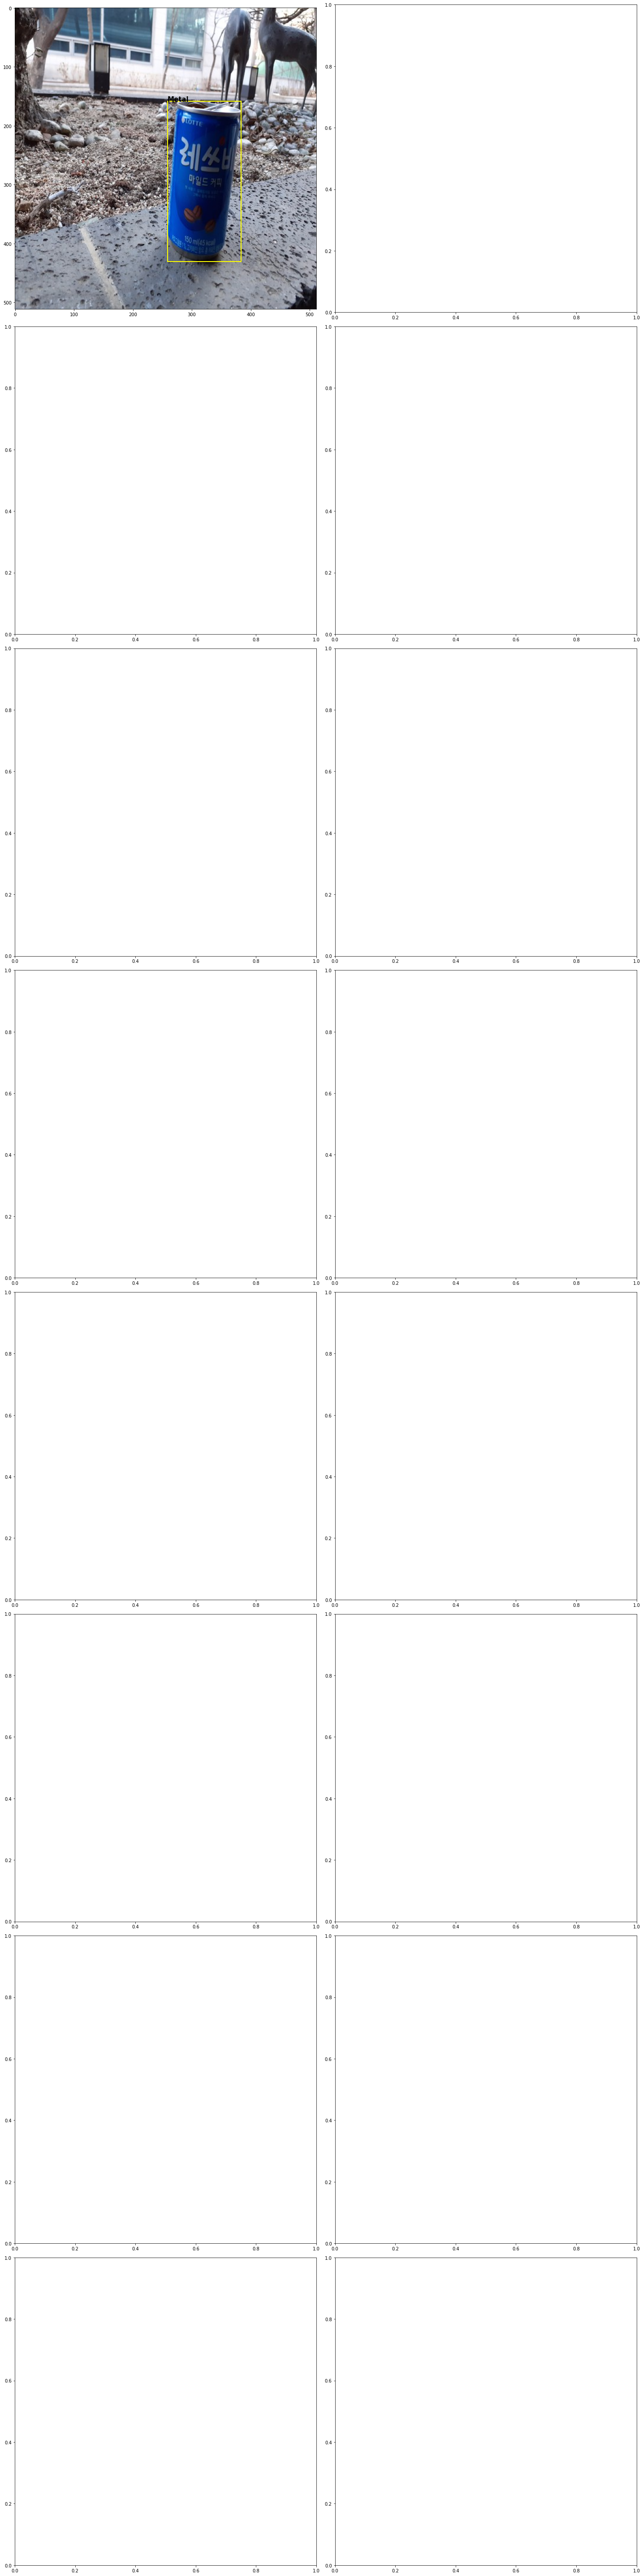

In [243]:
color = ['red', 'blue', 'black', 'green', 'yellow', 'orange', 'cyan', 'gray', 'purple', 'tomato', 'skyblue']
classes = ["UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass",
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
cnt=0
for idx, (imgs, target, image_id) in enumerate(train_data_loader):
    if idx == 2616:
        fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 80))
        plt.tight_layout()
        for i in range(batch_size):
            label = target[i]['labels']
            x = target[i]['boxes'][:, 0]
            y = target[i]['boxes'][:, 1]
            w = target[i]['boxes'][:, 2]
            h = target[i]['boxes'][:, 3]
            j = i // 2
            l = i % 2
            axes[j,l].imshow(imgs[i].permute([1,2,0]))
            for k in range(len(x)):
                axes[j,l].add_patch(
                 patches.Rectangle(
                    (x[k], y[k]),
                    w[k]-x[k],
                    h[k]-y[k],
                    edgecolor = color[label[k]],
                    facecolor = 'red',
                    fill=False,
                    linewidth=2
                 ))
                axes[j,l].text(x[k], y[k], classes[label[k]], fontsize=15, color='black', weight='bold')
        plt.show()
        break


In [6]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


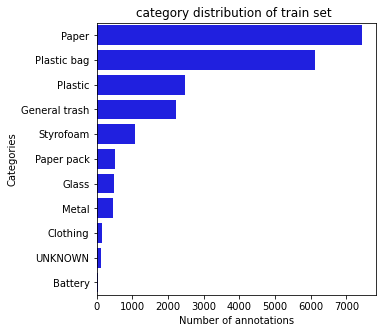

In [7]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [8]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [9]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


In [234]:
ann_df['1'].sum()

2225

### image마다 box개수, class개수 분포

In [24]:
ann_df = pd.DataFrame()

In [56]:
# from pandas import Series, DataFrame

# ann_df = {'img_id': [1],
#          'c1': [1],
#          'c2': [1],
#          'c3': [1],
#          'c4': [1],
#          'c5': [1],
#          'c6': [1],
#          'c7': [1],
#          'c8': [1],
#          'c9': [1],
#          'c10': [1],
#          'c11': [1]}

# ann = DataFrame(ann_df)
# ann

,img_id,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11
0,1,1,1,1,1,1,1,1,1,1,1,1


In [82]:
# cnt = 0
# for idx, (imgs, target, image_id) in enumerate(train_data_loader):
# #     if idx == 3:
# # #         print(target)
# #         label_list = target[0]['labels'].tolist()
# # #         print('/n')
# #         print(label_list)
# # #         print('/n')
# # #         print(image_id)
# #         break
#     cnt +=1 
    
# print(cnt)

2617


In [221]:
for idx, (imgs, target, image_id) in enumerate(train_data_loader):
    if idx == 2616:
        print(target)
        print('')
        print(image_id)
        break

({'boxes': tensor([[258.7000, 158.3000, 383.6000, 430.3000]]), 'labels': tensor([4]), 'image_id': tensor([2616]), 'area': tensor([27000.]), 'iscrowd': tensor([0])},)

([2616],)


In [252]:
idx_list = []
cl_list = []
bbox_cnt = []
for idx, (imgs, target, image_id) in enumerate(train_data_loader):
#   print(target[0]['labels']) # 한 image당(idx) 존재하는 class 정보
#     ann_df['index'] = idx
    label_list = target[0]['labels'].tolist()
    cnt = len(label_list)
    idx_list.append(image_id[0][0])
    cl_list.append(label_list)
    bbox_cnt.append(cnt)


In [246]:
idx_list

[([0],),
 ([1],),
 ([2],),
 ([3],),
 ([4],),
 ([5],),
 ([6],),
 ([7],),
 ([8],),
 ([9],),
 ([10],),
 ([11],),
 ([12],),
 ([13],),
 ([14],),
 ([15],),
 ([16],),
 ([17],),
 ([18],),
 ([19],),
 ([20],),
 ([21],),
 ([22],),
 ([23],),
 ([24],),
 ([25],),
 ([26],),
 ([27],),
 ([28],),
 ([29],),
 ([30],),
 ([31],),
 ([32],),
 ([33],),
 ([34],),
 ([35],),
 ([36],),
 ([37],),
 ([38],),
 ([39],),
 ([40],),
 ([41],),
 ([42],),
 ([43],),
 ([44],),
 ([45],),
 ([46],),
 ([47],),
 ([48],),
 ([49],),
 ([50],),
 ([51],),
 ([52],),
 ([53],),
 ([54],),
 ([55],),
 ([56],),
 ([57],),
 ([58],),
 ([59],),
 ([60],),
 ([61],),
 ([62],),
 ([63],),
 ([64],),
 ([65],),
 ([66],),
 ([67],),
 ([68],),
 ([69],),
 ([70],),
 ([71],),
 ([72],),
 ([73],),
 ([74],),
 ([75],),
 ([76],),
 ([77],),
 ([78],),
 ([79],),
 ([80],),
 ([81],),
 ([82],),
 ([83],),
 ([84],),
 ([85],),
 ([86],),
 ([87],),
 ([88],),
 ([89],),
 ([90],),
 ([91],),
 ([92],),
 ([93],),
 ([94],),
 ([95],),
 ([96],),
 ([97],),
 ([98],),
 ([99],),
 ([100],),

In [253]:
ann_df = pd.DataFrame()
ann_df['id'] = idx_list
ann_df['class'] = cl_list
ann_df['count'] = bbox_cnt

ann_df

,id,class,count
0,0,"[8, 8, 8, 1, 1, 1, 1, 8, 1, 1, 8, 8, 1, 1]",14
1,1,[6],1
2,2,"[6, 4]",2
3,3,"[6, 6]",2
4,4,[1],1
...,...,...,...
2612,2612,[4],1
2613,2613,"[7, 6, 2, 2, 8, 7, 6]",7
2614,2614,"[2, 7, 1, 1]",4
2615,2615,"[2, 2, 2, 2, 2, 2, 2, 2]",8


In [251]:
val_df = pd.DataFrame()
val_df['id'] = idx_list
val_df['class'] = cl_list
val_df['count'] = bbox_cnt

val_df

,id,class,count
0,0,"[8, 8, 6, 5, 5, 6, 5, 6, 6, 8, 8, 8, 8, 8, 8, ...",17
1,1,"[2, 6]",2
2,2,"[0, 1, 8, 8, 1, 8, 8]",7
3,3,"[2, 8, 8, 8, 8, 8, 8, 8, 8, 8]",10
4,4,"[8, 8, 8, 8, 3, 8]",6
...,...,...,...
650,650,"[1, 8]",2
651,651,[2],1
652,652,"[6, 3, 1, 6, 1, 4, 4, 1, 4, 4, 3, 6, 4]",13
653,653,"[2, 1, 1, 2, 2, 2, 2, 2, 2]",9


In [276]:
def cls_cnt(ann_df):
    cls_l = ann_df['class'].count(10)
    return cls_l

In [277]:
# for i in range(1,12,1):
ann_df['11'] = ann_df.apply(cls_cnt, axis=1)
val_df['11'] = val_df.apply(cls_cnt, axis=1)
# display(ann_df, val_df)

In [278]:
display(ann_df, val_df)

,id,class,count,1,2,3,4,5,6,7,8,9,10,11
0,0,"[8, 8, 8, 1, 1, 1, 1, 8, 1, 1, 8, 8, 1, 1]",14,0,8,0,0,0,0,0,0,6,0,0
1,1,[6],1,0,0,0,0,0,0,1,0,0,0,0
2,2,"[6, 4]",2,0,0,0,0,1,0,1,0,0,0,0
3,3,"[6, 6]",2,0,0,0,0,0,0,2,0,0,0,0
4,4,[1],1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2612,2612,[4],1,0,0,0,0,1,0,0,0,0,0,0
2613,2613,"[7, 6, 2, 2, 8, 7, 6]",7,0,0,2,0,0,0,2,2,1,0,0
2614,2614,"[2, 7, 1, 1]",4,0,2,1,0,0,0,0,1,0,0,0
2615,2615,"[2, 2, 2, 2, 2, 2, 2, 2]",8,0,0,8,0,0,0,0,0,0,0,0


,id,class,count,1,2,3,4,5,6,7,8,9,10,11
0,0,"[8, 8, 6, 5, 5, 6, 5, 6, 6, 8, 8, 8, 8, 8, 8, ...",17,0,0,0,0,0,4,4,0,9,0,0
1,1,"[2, 6]",2,0,0,1,0,0,0,1,0,0,0,0
2,2,"[0, 1, 8, 8, 1, 8, 8]",7,1,2,0,0,0,0,0,0,4,0,0
3,3,"[2, 8, 8, 8, 8, 8, 8, 8, 8, 8]",10,0,0,1,0,0,0,0,0,9,0,0
4,4,"[8, 8, 8, 8, 3, 8]",6,0,0,0,1,0,0,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,650,"[1, 8]",2,0,1,0,0,0,0,0,0,1,0,0
651,651,[2],1,0,0,1,0,0,0,0,0,0,0,0
652,652,"[6, 3, 1, 6, 1, 4, 4, 1, 4, 4, 3, 6, 4]",13,0,3,0,2,5,0,3,0,0,0,0
653,653,"[2, 1, 1, 2, 2, 2, 2, 2, 2]",9,0,2,7,0,0,0,0,0,0,0,0


In [257]:
ann_df['1'].sum()

128

In [280]:
ann_df.to_csv('train_info.csv', index=None)
val_df.to_csv('val_info.csv', index=None)

In [132]:
# ann_df = ann_df.drop(['class'], axis=1)
# val_df = val_df.drop(['class'], axis=1)

### 분포 확인

In [281]:
ann_df.describe()

,id,count,1,2,3,4,5,6,7,8,9,10,11
count,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000
mean,1308.000000,8.068781,0.048911,0.850210,2.846007,0.201376,0.171571,0.186473,0.944593,0.410394,2.336263,0.019106,0.053878
std,755.607151,8.934386,0.332801,1.535423,5.210146,0.821369,1.181529,1.249618,2.367188,1.366825,3.539969,0.297187,0.322098
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,654.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1308.000000,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1962.000000,12.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
max,2616.000000,64.000000,9.000000,28.000000,45.000000,15.000000,36.000000,23.000000,33.000000,21.000000,37.000000,8.000000,6.000000


In [282]:
val_df.describe()

,id,count,1,2,3,4,5,6,7,8,9,10,11
count,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000
mean,327.000000,8.067176,0.048855,0.850382,2.844275,0.201527,0.172519,0.186260,0.943511,0.410687,2.334351,0.019847,0.054962
std,189.226496,9.232227,0.391884,1.588056,5.260219,0.683352,0.690151,1.387624,2.266938,1.726978,3.348234,0.470444,0.379162
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,163.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,327.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,490.500000,12.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
max,654.000000,72.000000,8.000000,18.000000,46.000000,9.000000,11.000000,26.000000,21.000000,34.000000,19.000000,12.000000,5.000000


### dataset count 분포

No handles with labels found to put in legend.


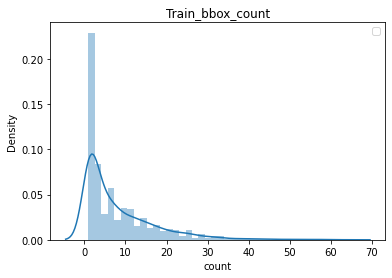

In [193]:
# sns.distplot(sample.loc[sample['label']==1, 'total_15'], label='label=1')

sns.distplot(ann_df.loc[:, 'count'])
# sns.distplot(val_df.loc[:, 'count'])

plt.title('Train_bbox_count')
plt.legend()
plt.show()

(array([1643.,  436.,  264.,  155.,   57.,   28.,   17.,    8.,    6.,
           3.]),
 array([ 1. ,  7.3, 13.6, 19.9, 26.2, 32.5, 38.8, 45.1, 51.4, 57.7, 64. ]),
 <BarContainer object of 10 artists>)

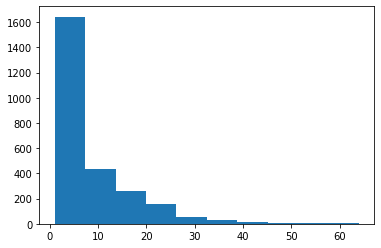

In [147]:
# plt.hist(ann_df['count'], bins=10)

No handles with labels found to put in legend.


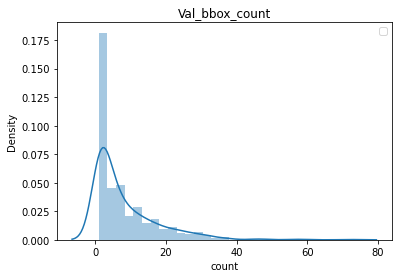

In [194]:
sns.distplot(val_df.loc[:, 'count'])

plt.title('Val_bbox_count')
plt.legend()
plt.show()

In [9]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


### class별 분포

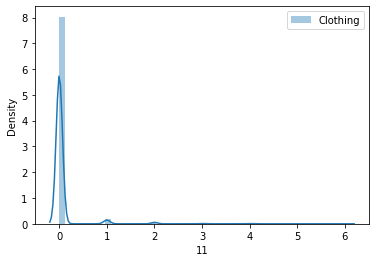

In [296]:
sns.distplot(ann_df['11'], label="Clothing")

plt.legend()
plt.show()

### 산점도

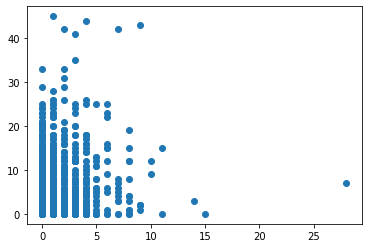

In [305]:
plt.scatter(ann_df['2'], ann_df['3'])
plt.show()

No handles with labels found to put in legend.


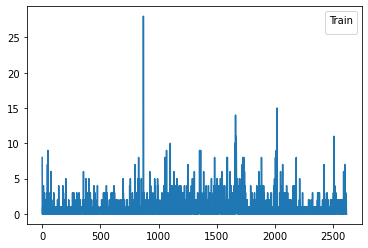

In [152]:
plt.plot(ann_df['1'])


### Region size 분포

In [307]:
for idx, (imgs, target, image_id) in enumerate(train_data_loader):
    if idx == 0:
        print(target)
        print('')
        print(image_id)
        break

({'boxes': tensor([[128.2000, 107.0000, 509.5000, 455.8000],
        [331.9000, 193.4000, 396.7000, 241.8000],
        [356.2000, 232.8000, 386.7000, 249.9000],
        [226.7000, 183.4000, 263.6000, 213.7000],
        [256.0000, 181.7000, 286.8000, 209.0000],
        [264.3000, 185.1000, 330.8000, 213.2000],
        [294.3000, 192.6000, 346.6000, 227.4000],
        [230.1000, 211.9000, 259.7000, 248.6000],
        [236.5000, 209.1000, 303.0000, 244.3000],
        [267.9000, 218.4000, 292.6000, 227.7000],
        [249.1000, 201.5000, 273.1000, 223.1000],
        [154.8000, 232.1000, 185.4000, 268.3000],
        [174.7000, 207.6000, 236.3000, 265.3000],
        [  0.0000, 178.9000,  84.1000, 363.4000]]), 'labels': tensor([8, 8, 8, 1, 1, 1, 1, 8, 1, 1, 8, 8, 1, 1]), 'image_id': tensor([0]), 'area': tensor([79999.0000,  1623.0000,   327.5000,   369.5000,   400.0000,  1043.0000,
          655.5000,   373.0000,  1273.0000,   153.0000,   211.5000,   680.5000,
         2249.0000,  7564.5000])

In [313]:
# img_id_list = []
# region_size = []
for idx, (imgs, target, image_id) in enumerate(train_data_loader):
    if idx==2616:  
#         print(target[0]['boxes']) # 한 image당(idx) 존재하는 class 정보
        a = target[0]['boxes'].tolist()
        for x_min, y_min, x_max, y_max in a:
            size = (x_max-x_min)*(y_max-y_min)
            aa = round(size,0)
            print(aa)
        break

33973.0


In [341]:
img_id_list = []
box_cnt_list = []
region_size = []
id_region_size = []
for idx, (imgs, target, image_id) in enumerate(train_data_loader):
#     label_list = target[0]['labels'].tolist()
    img_id_list.append(image_id[0][0])
    a = target[0]['boxes'].tolist()
    id_sz_list = []
    cnt = 0
    for x_min, y_min, x_max, y_max in a:
        cnt+=1
        size = (x_max-x_min)*(y_max-y_min)
        re_size = round(size,0)
        region_size.append(re_size)
        id_sz_list.append(re_size)
    id_region_size.append(id_sz_list)
    box_cnt_list.append(cnt)

In [328]:
# img_d_list
# sum(box_cnt_list)
# len(region_size)
# id_region_size

In [333]:
# box_df = pd.DataFrame()
# box_df['id'] = img_id_list
# box_df['box_cnt'] = box_cnt_list
# box_df['region_size'] = id_region_size

box_df

,id,box_cnt,region_size
0,0,14,"[132997.0, 3136.0, 522.0, 1118.0, 841.0, 1869...."
1,1,1,[41119.0]
2,2,2,"[66280.0, 1300.0]"
3,3,2,"[113360.0, 17496.0]"
4,4,1,[62733.0]
...,...,...,...
2612,2612,1,[68142.0]
2613,2613,7,"[16798.0, 2095.0, 2678.0, 3685.0, 2509.0, 2080..."
2614,2614,4,"[92606.0, 65150.0, 35880.0, 41836.0]"
2615,2615,8,"[50299.0, 1547.0, 1995.0, 5933.0, 2396.0, 427...."


In [342]:
val_box_df = pd.DataFrame()
val_box_df['id'] = img_id_list
val_box_df['box_cnt'] = box_cnt_list
val_box_df['region_size'] = id_region_size

val_box_df

,id,box_cnt,region_size
0,0,17,"[25872.0, 3826.0, 5908.0, 21466.0, 23472.0, 14..."
1,1,2,"[75883.0, 14582.0]"
2,2,7,"[6652.0, 322.0, 32495.0, 25094.0, 4916.0, 1458..."
3,3,10,"[31952.0, 998.0, 2422.0, 4149.0, 911.0, 7316.0..."
4,4,6,"[1149.0, 8421.0, 30206.0, 19189.0, 1057.0, 369.0]"
...,...,...,...
650,650,2,"[32289.0, 16912.0]"
651,651,1,[36269.0]
652,652,13,"[33008.0, 1369.0, 2160.0, 137314.0, 1920.0, 34..."
653,653,9,"[1256.0, 2343.0, 1253.0, 64992.0, 4703.0, 6873..."


In [343]:
# box_df.to_csv('train_box_size.csv', index=None)
val_box_df.to_csv('val_box_size.csv', index=None)

<function matplotlib.pyplot.show(close=None, block=None)>

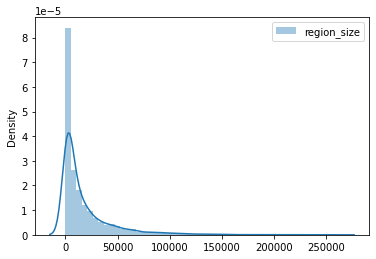

In [344]:
# class 구분 없이 전체 region 사이즈 분포
sns.distplot(region_size, label="region_size")

plt.legend()
plt.show

In [345]:
region_df = pd.DataFrame()
region_df['size'] = region_size

region_df

,size
0,25872.0
1,3826.0
2,5908.0
3,21466.0
4,23472.0
...,...
5279,30724.0
5280,10749.0
5281,1372.0
5282,3625.0


In [346]:
region_df.describe()

,size
count,5284.000000
mean,18137.387585
std,27661.357547
min,15.000000
25%,1757.500000
50%,7048.000000
75%,22271.250000
max,261990.000000


In [354]:
box_df = pd.read_csv('val_box_size.csv')
box_df

,id,box_cnt,region_size
0,0,17,"[25872.0, 3826.0, 5908.0, 21466.0, 23472.0, 14..."
1,1,2,"[75883.0, 14582.0]"
2,2,7,"[6652.0, 322.0, 32495.0, 25094.0, 4916.0, 1458..."
3,3,10,"[31952.0, 998.0, 2422.0, 4149.0, 911.0, 7316.0..."
4,4,6,"[1149.0, 8421.0, 30206.0, 19189.0, 1057.0, 369.0]"
...,...,...,...
650,650,2,"[32289.0, 16912.0]"
651,651,1,[36269.0]
652,652,13,"[33008.0, 1369.0, 2160.0, 137314.0, 1920.0, 34..."
653,653,9,"[1256.0, 2343.0, 1253.0, 64992.0, 4703.0, 6873..."


In [356]:
df = val_df.loc[:,['id', 'class']]
val_box_df = pd.merge(box_df, df, on='id', how='left')
val_box_df

,id,box_cnt,region_size,class
0,0,17,"[25872.0, 3826.0, 5908.0, 21466.0, 23472.0, 14...","[8, 8, 6, 5, 5, 6, 5, 6, 6, 8, 8, 8, 8, 8, 8, ..."
1,1,2,"[75883.0, 14582.0]","[2, 6]"
2,2,7,"[6652.0, 322.0, 32495.0, 25094.0, 4916.0, 1458...","[0, 1, 8, 8, 1, 8, 8]"
3,3,10,"[31952.0, 998.0, 2422.0, 4149.0, 911.0, 7316.0...","[2, 8, 8, 8, 8, 8, 8, 8, 8, 8]"
4,4,6,"[1149.0, 8421.0, 30206.0, 19189.0, 1057.0, 369.0]","[8, 8, 8, 8, 3, 8]"
...,...,...,...,...
650,650,2,"[32289.0, 16912.0]","[1, 8]"
651,651,1,[36269.0],[2]
652,652,13,"[33008.0, 1369.0, 2160.0, 137314.0, 1920.0, 34...","[6, 3, 1, 6, 1, 4, 4, 1, 4, 4, 3, 6, 4]"
653,653,9,"[1256.0, 2343.0, 1253.0, 64992.0, 4703.0, 6873...","[2, 1, 1, 2, 2, 2, 2, 2, 2]"


In [357]:
# box_df.to_csv('train_box_size.csv', index=None)
# val_box_df.to_csv('val_box_size.csv', index=None)

In [358]:
train_box_df = pd.read_csv('train_box_size.csv')
val_box_df = pd.read_csv('val_box_size.csv')

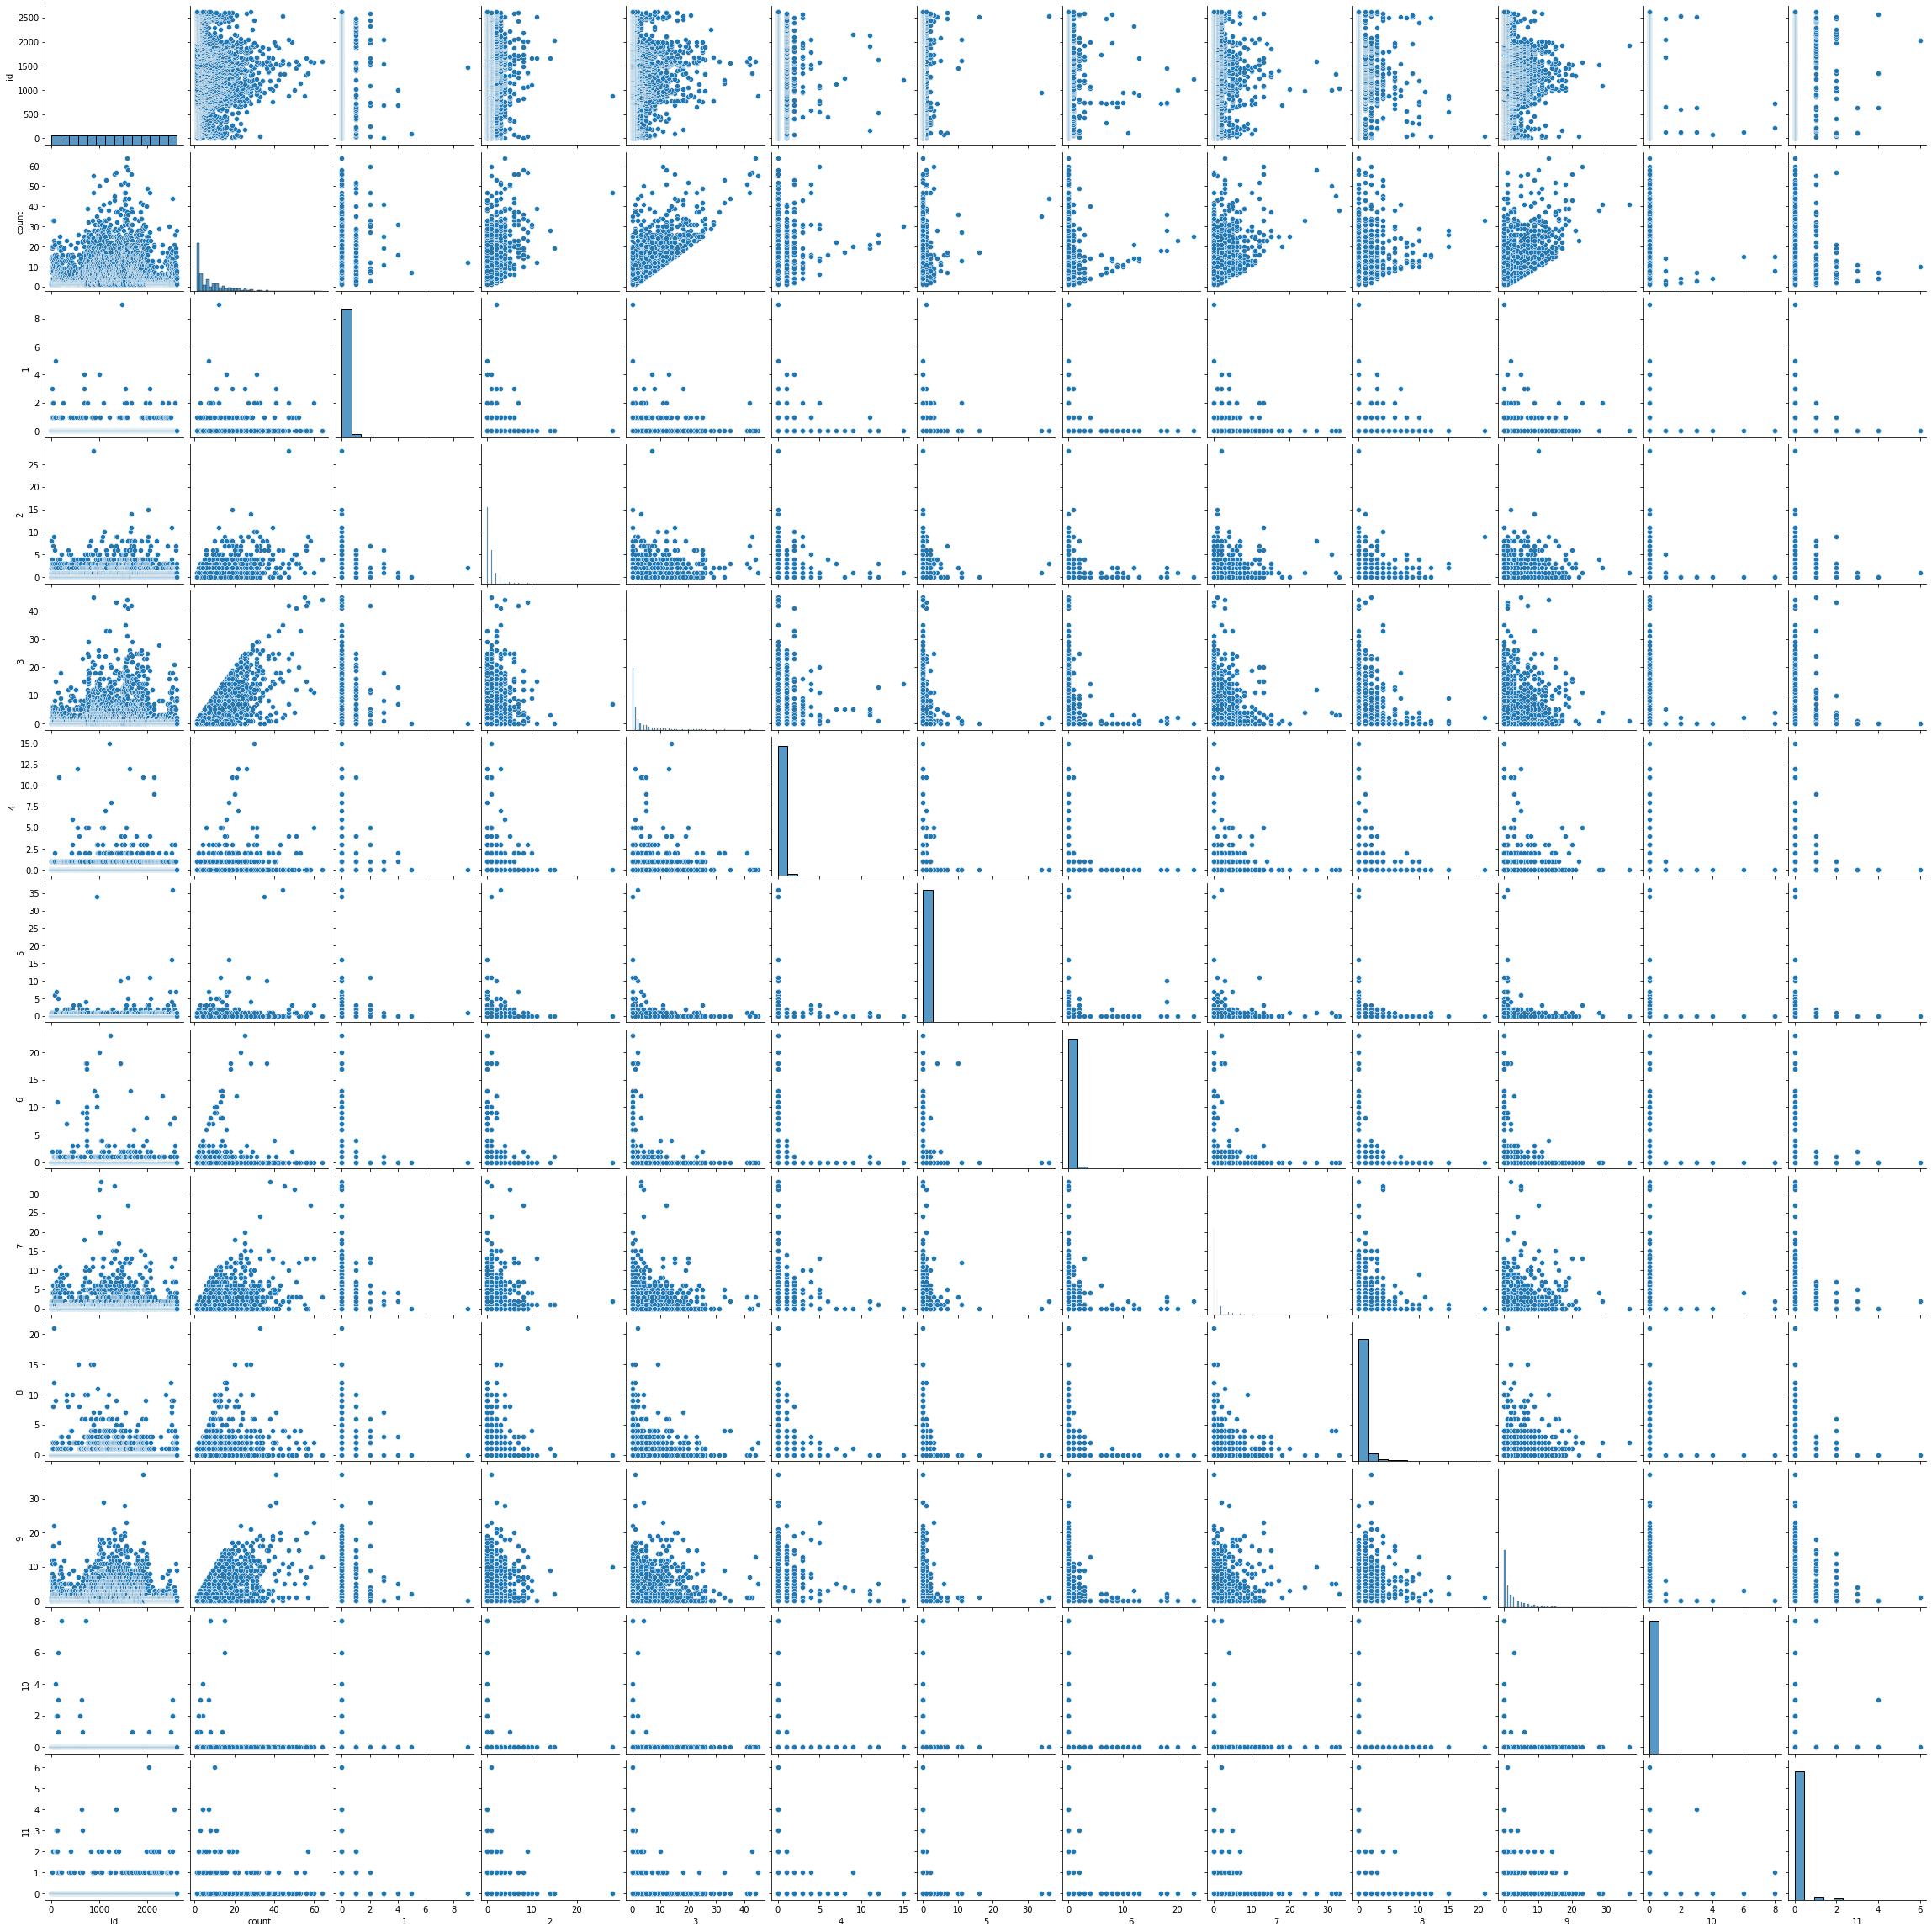

In [362]:
sns.pairplot(data = ann_df)

### class별 region 분포

In [367]:
region_size_2 = []
class_list_2 = []
id_region_size_2 = []
for idx, (imgs, target, image_id) in enumerate(train_data_loader):
    label_list = target[0]['labels'].tolist()
    img_id_list.append(image_id[0][0])
    a = target[0]['boxes'].tolist()
    id_sz_list = []
    cnt = 0
    for x_min, y_min, x_max, y_max in a:
        cnt+=1
        size = (x_max-x_min)*(y_max-y_min)
        re_size = round(size,0)
        region_size_2.append(re_size)
        id_sz_list.append(re_size)
    id_region_size_2.append(id_sz_list)
    class_list_2.append(label_list)

In [371]:
# region_size_2
# class_list_2
# id_region_size_2

In [378]:
label_size = [[] for _ in range(12)]
for i in range(len(class_list_2)):
    for j, label in enumerate(class_list_2[i]):
        label_size[label].append(id_region_size_2[i][j])

In [382]:
len(label_size[10])

141

In [466]:
df = pd.DataFrame()
df['11'] = label_size[10]
df

,11
0,94153.0
1,23108.0
2,36168.0
3,139587.0
4,99486.0
...,...
136,65002.0
137,9763.0
138,211523.0
139,2024.0


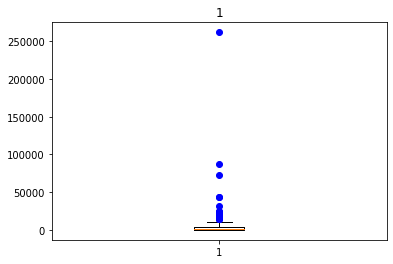

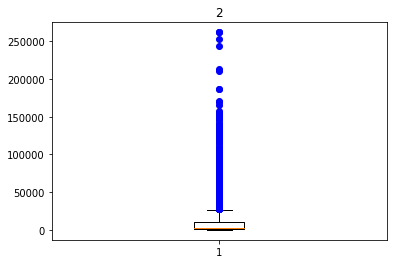

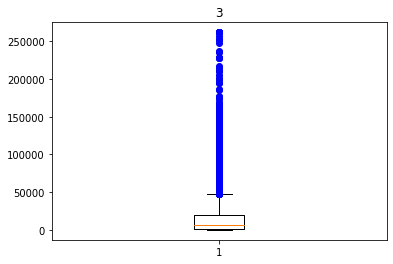

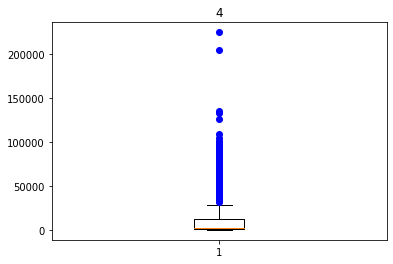

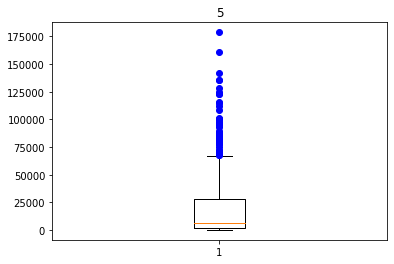

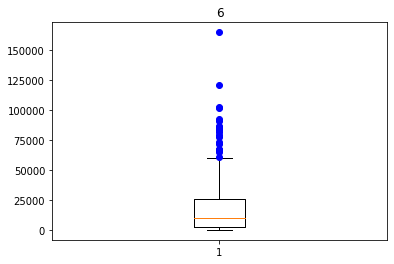

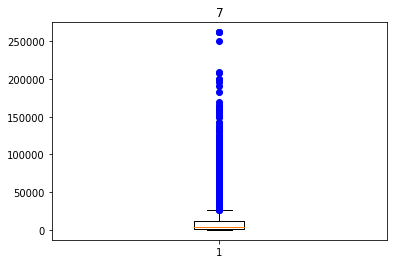

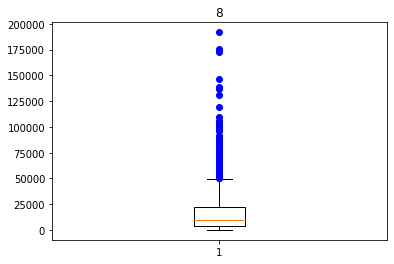

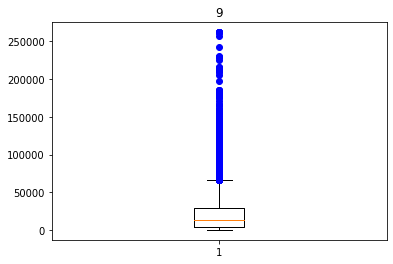

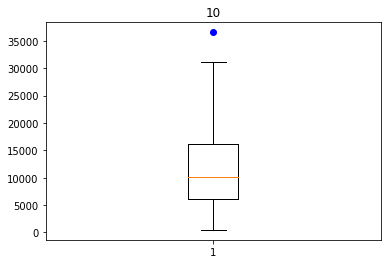

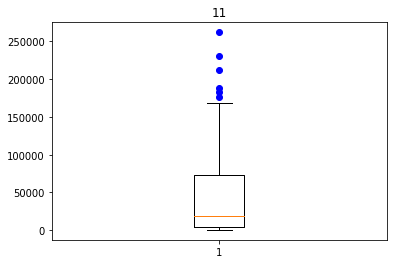

In [473]:
for i in range(11):
    df = pd.DataFrame()
    df[i+1] = label_size[i]
    plt.boxplot(df[i+1], sym="bo")
    plt.title(i+1)
    plt.show()

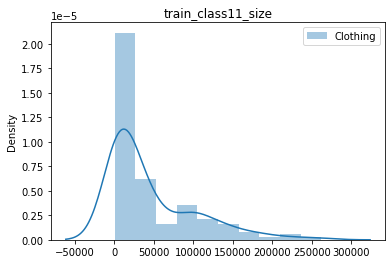

In [433]:
sns.distplot(df, label='Clothing')

plt.title('train_class11_size')
plt.legend()
plt.show()

In [434]:
df.describe()

,11
count,141.000000
mean,45498.716312
std,55492.295385
min,464.000000
25%,4369.000000
50%,19534.000000
75%,72638.000000
max,261990.000000


In [399]:
# sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


In [435]:
region_size_v = []
class_list_v = []
id_region_size_v = []
for idx, (imgs, target, image_id) in enumerate(val_data_loader):
    label_list = target[0]['labels'].tolist()
#     img_id_list.append(image_id[0][0])
    a = target[0]['boxes'].tolist()
    id_sz_list = []
    cnt = 0
    for x_min, y_min, x_max, y_max in a:
        cnt+=1
        size = (x_max-x_min)*(y_max-y_min)
        re_size = round(size,0)
        region_size_v.append(re_size)
        id_sz_list.append(re_size)
    id_region_size_v.append(id_sz_list)
    class_list_v.append(label_list)

In [436]:
label_size_v = [[] for _ in range(12)]
for i in range(len(class_list_v)):
    for j, label in enumerate(class_list_v[i]):
        label_size_v[label].append(id_region_size_v[i][j])

In [462]:
df = pd.DataFrame()
df_v = pd.DataFrame()
df['2'] = label_size[1]
df_v['2'] = label_size_v[1]
# display(df, df_v)

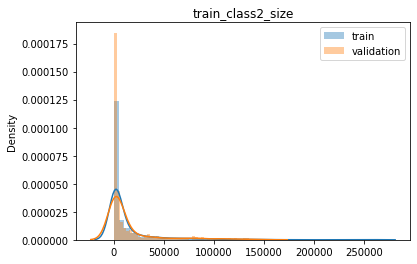

In [465]:
sns.distplot(df, label='train')
sns.distplot(df_v, label='validation')

plt.title('train_class2_size')
plt.legend()
plt.show()

In [479]:
heatmap = [[0 for _ in range(512)] for _ in range(512)]
len(heatmap[0])

512

In [484]:
for idx, (imgs, target, image_id) in enumerate(val_data_loader):
    label_list = target[0]['labels'].tolist()
#     img_id_list.append(image_id[0][0])
    a = target[0]['boxes'].tolist()
    id_sz_list = []
    cnt = 0
    for x_min, y_min, x_max, y_max in a:
        x_min = int(round(x_min,0))
        y_min = int(round(y_min,0))
        x_max = int(round(x_max,0))
        y_max = int(round(y_max,0))
        for i in range(y_min,y_max+1,1):
            for j in range(x_min,x_max+1,1):
                if i>=0 and i<512 and j>=0 and j<512:
                    heatmap[i][j] += 1

[32,
 33,
 33,
 33,
 33,
 33,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 35,
 34,
 34,
 34,
 34,
 35,
 35,
 36,
 36,
 36,
 36,
 36,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 38,
 39,
 39,
 39,
 39,
 39,
 40,
 40,
 42,
 42,
 42,
 42,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 42,
 42,
 43,
 43,
 43,
 43,
 43,
 43,
 44,
 43,
 43,
 43,
 43,
 42,
 42,
 44,
 44,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 42,
 43,
 43,
 44,
 44,
 44,
 44,
 44,
 45,
 45,
 45,
 46,
 45,
 44,
 44,
 44,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 44,
 44,
 45,
 46,
 47,
 48,
 49,
 49,
 49,
 49,
 49,
 49,
 50,
 49,
 48,
 48,
 48,
 49,
 49,
 48,
 48,
 48,
 49,
 49,
 48,
 48,
 48,
 48,
 48,
 48,
 47,
 47,
 47,
 46,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 48,
 49,
 49,
 50,
 50,
 50,
 50,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 48,
 47,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 45,
 47,
 47,
 48,
 48,
 48,
 47,
 47,
 47,
 44,
 44,
 44,
 44,
 45,
 45,
 45,
 45,
 45,
 46,
 46,


In [486]:
heatmap_df = pd.DataFrame(heatmap)

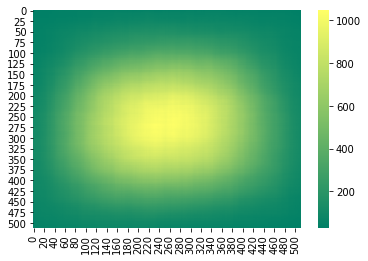

In [489]:
# heatmap_df
# heatmap_df.style.background_gradient(cmap='summer')
sns.heatmap(heatmap_df, cmap='summer')
plt.savefig('heatmap.png')

In [490]:
heatmap_df.to_csv('heatmap.csv',index=None)